In [8]:
# ! pip install tqdm tensorflow_hub xlrd nltk matplotlib

In [2]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from tqdm import tqdm
import nltk
import os
import re
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
from nltk.tokenize import sent_tokenize

In [3]:
tqdm.pandas()

In [4]:
def split_to_sentences(data):
    sentences = [s for d in data for s in d.split('\n')]
    sentences = [s.strip() for s in sentences]
    sentences = [re.sub('&#39;', '\'', s) for s in sentences]
    sentences = [re.sub('…', '...', s) for s in sentences]
    sentences = [s for line in sentences for s in sent_tokenize(line) if s]
    new_sentences = []
    for s in sentences:
        if len(s)>=512:
            new_sentences += s.split(',')
        else:
            new_sentences.append(s)
    return new_sentences

In [31]:
data = []
dirname = 'data/thoughts/Thoughts_en/'
for fname in tqdm(os.listdir(dirname)):
    if not fname.endswith('.docx'):
        continue
    with open(f"{dirname}/{fname}") as f:
        data +=  [f.read()]

100%|██████████| 438/438 [00:03<00:00, 125.55it/s]


In [32]:
len(data)

437

In [33]:
sentences = split_to_sentences(data)

In [34]:
len(sentences)

12227

In [35]:
df = pd.read_excel('data/SUBTLEXusfrequencyabove1.xls')
df['word'] = df['Word'].str.lower()
df = df.set_index('word')
freqs = df['FREQcount']

In [36]:
words = [w for s in sentences for w in nltk.word_tokenize(s.lower())]

In [37]:
len(words)

94406

# Deal with OOV

In [38]:
oov = [word for word in words if re.match('[a-z]+', word) and word not in freqs]

In [39]:
oov_cnt = Counter(oov)

In [40]:
pd.DataFrame(oov_cnt.most_common(), columns=['word','freq']).to_csv('data/oov.csv', index=False)

In [41]:
oov_df = pd.read_csv('data/oov 3.csv')

In [42]:
oov_df = oov_df.dropna()

In [43]:
oov_df = oov_df.set_index('word')

In [44]:
all_data = "||".join(data)

In [45]:
# "||" in all_data -> false

In [46]:
oov_df['found'] = oov_df.apply(lambda x: len(re.findall(f"\\b{x.name}\\b", all_data, re.IGNORECASE)), axis=1)

In [47]:
for word,alt in dict(oov_df['Alternative']).items():
    all_data = re.sub(f"\\b{word}\\b", alt, all_data, flags = re.IGNORECASE)


In [48]:
oov_df['new found'] = oov_df.apply(lambda x: len(re.findall(f"\\b{x.name}\\b", all_data, re.IGNORECASE)), axis=1)

In [49]:
data = all_data.split('||')

# Sentence embeddings

In [50]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


In [51]:
sentences = split_to_sentences(data)

In [52]:
len(sentences)

12227

In [53]:
sent_cnt = Counter(sentences)

In [54]:
len(sent_cnt)

10312

In [55]:
sent_cnt.most_common(10)

[('Good', 264),
 ('What else?', 179),
 ('Do not know', 178),
 ('What more?', 71),
 ('cool', 69),
 ('Maybe', 49),
 ("what's going on?", 41),
 ('Okay', 39),
 ('What about you?', 37),
 ('Not too much', 36)]

In [56]:
# !pip install tensorflow-hub

In [57]:
uniq = list(sent_cnt.keys())

In [58]:
batch_size = 100
batches = []
for i in tqdm(range(len(uniq)//batch_size)):
    embeddings = embed(uniq[i*batch_size:(i+1)*batch_size])
    batches += [embeddings]
embeddings = embed(uniq[(i+1)*batch_size:])
batches += [embeddings]    

100%|██████████| 103/103 [00:02<00:00, 40.62it/s]


In [59]:
embeddings = tf.concat(batches, axis=0)

In [60]:
embeddings = embeddings.numpy()

In [61]:
np.savetxt('data/thoughts/embeddings.csv', embeddings, delimiter='\t')

In [62]:
embeddings = np.genfromtxt('data/thoughts/embeddings.csv', delimiter='\t')

In [63]:
embeddings.shape

(10312, 512)

In [64]:
data = '\n'.join(uniq) + '\n'

In [65]:
data = re.sub('\t', '    ', data)

In [66]:
with open('data/thoughts/sentences.txt', 'w') as f:
    f.write(data)

In [67]:
with open('data/thoughts/sentences.txt') as f:
    data = f.read()

In [68]:
#TODO: sentence embeddings
#TODO: sentence clustering
#TODO: topic analysis (over time)
#TODO: sentiment analysis (over time)

In [69]:
embeddings_df = pd.DataFrame(embeddings)

In [70]:
embeddings_df.index = data.strip('\n').split('\n')

In [71]:
embeddings_df.to_csv('data/thoughts/embeddings.df.csv')

In [72]:
embeddings_df_sm = embeddings_df.sample(1000)

In [73]:
embeddings_sm = embeddings_df_sm.values

In [5]:
embeddings_df = pd.read_csv('data/thoughts/embeddings.df.csv', index_col=0)

# Cluster

In [48]:
adj_mat = cdist(embeddings_sm, embeddings_sm)

In [49]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(10, affinity='precomputed', n_init=100,
                         assign_labels='discretize')
# sc.fit_predict(adj_mat)  

In [50]:
from sklearn.cluster import KMeans

In [62]:
def calculate_WSS(points,k=2):
    kmeans = KMeans(n_clusters = k).fit(points)
    centers = np.array([kmeans.cluster_centers_[l] for l in kmeans.labels_])
    sse = ((points-centers)**2).sum()
    return sse

sse = []
for k in tqdm(range(10)):
    sse.append(calculate_WSS(embeddings))
# for k in tqdm(range(11, 20)):
#     sse.append(calculate_WSS(embeddings,k))
# for k in tqdm(range(20,30)):
#     sse.append(calculate_WSS(embeddings,k))





100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


In [52]:
# sse10 = calculate_WSS(embeddings,10)

In [53]:
# sse = sse[:8]+[sse10]+sse[8:]

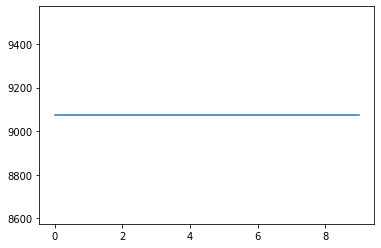

In [63]:
plt.plot(sse)

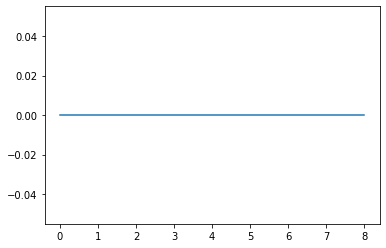

In [64]:
plt.plot([sse[i]-sse[i-1] for i in range(1,len(sse))])

In [65]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax+1)):
    kmeans = KMeans(n_clusters = k).fit(embeddings)
    labels = kmeans.labels_
    sil.append(silhouette_score(embeddings, labels, metric = 'euclidean'))

100%|██████████| 9/9 [02:02<00:00, 13.58s/it]


In [ ]:
for k in tqdm(range(kmax+1, 2*kmax)):
    kmeans = KMeans(n_clusters = k).fit(embeddings)
    labels = kmeans.labels_
    sil.append(silhouette_score(embeddings, labels, metric = 'euclidean'))

 11%|█         | 1/9 [00:15<02:07, 15.97s/it]

In [ ]:
for k in tqdm(range(2*kmax, 3*kmax)):
    kmeans = KMeans(n_clusters = k).fit(embeddings)
    labels = kmeans.labels_
    sil.append(silhouette_score(embeddings, labels, metric = 'euclidean'))

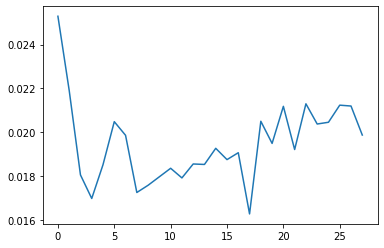

In [69]:
plt.plot(sil)

In [76]:
# ! pip install umap-learn

# Dimentionality Reduction

In [95]:
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [84]:
reducer = umap.UMAP()

In [80]:
scaled_embeddinbgs = StandardScaler().fit_transform(embeddings)

In [85]:
umap_embedding = reducer.fit_transform(scaled_embeddinbgs)

Text(0.5, 1.0, 'UMAP projection of the Penguin dataset')

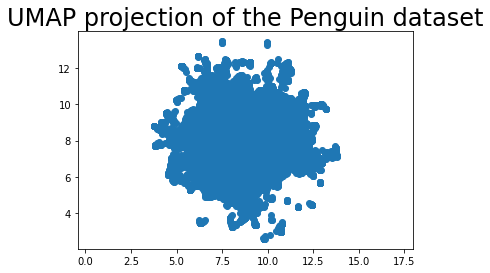

In [86]:
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1])
#     c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24)

In [89]:
pca = PCA(n_components=2)

In [90]:
pca.fit(embeddings)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [91]:
pca.explained_variance_ratio_

array([0.03307248, 0.02561601])

In [92]:
pca_embeddings = pca.fit_transform(embeddings, None)

Text(0.5, 1.0, 'PCA projection')

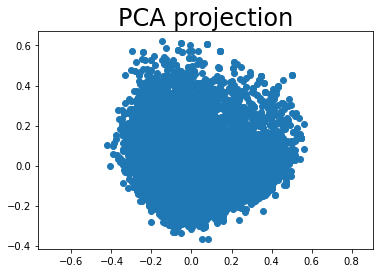

In [94]:
plt.scatter(
    pca_embeddings[:, 0],
    pca_embeddings[:, 1])
#     c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA projection', fontsize=24)

In [97]:
tsne_embedded = TSNE(n_components=2,init='random').fit_transform(embeddings)

Text(0.5, 1.0, 'TSNE projection')

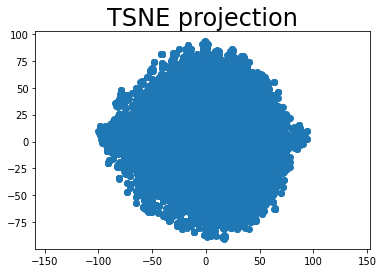

In [99]:
plt.scatter(
    tsne_embedded[:, 0],
    tsne_embedded[:, 1])
#     c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('TSNE projection', fontsize=24)

# Sentiment Analysis

In [12]:
# ! pip install transformers==3.1
# ! pip3 install --upgrade tensorflow-gpu

In [6]:
from transformers import pipeline
import time

/usr/local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
sentiment_pipeline = pipeline("sentiment-analysis")

All model checkpoint weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [77]:
len(embeddings_df)

10312

In [15]:
sub_df = embeddings_df.index[2800-1:2800+100]

In [16]:
min(sub_df, key=len)

'Now'

In [17]:
data = list(sub_df)
sentiments = sentiment_pipeline(data)


In [27]:
embeddings_sentiments = []

In [28]:
sentiment_df = pd.DataFrame([], columns=['label','score'])

In [ ]:
for i in tqdm(range(len(embeddings_sentiments),len(embeddings_df),100)):
    data = list(embeddings_df.iloc[i:i+100].index)
    embeddings_sentiments += sentiment_pipeline(data)
    df = pd.DataFrame(embeddings_sentiments)
    sentiment_df = pd.concat([sentiment_df,df])
    sentiment_df.to_csv('data/thoughts/sentiment.csv')


100%|██████████| 104/104 [08:57<00:00,  5.17s/it]


In [33]:
pd.read_csv('data/thoughts/sentiment.csv', index_col=0).shape

(545912, 2)